# Mounting drive and getting data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/daraz' '/content/'

# Installing Dependencies

In [ ]:
%%capture
!pip install fasttext
!pip install flask-ngrok

# Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
import fasttext
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from flask import Flask
from flask_ngrok import run_with_ngrok
from flask import request

# Loading Data

In [ ]:
anime_df = pd.read_csv('/content/daraz/anime.csv')
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [ ]:
rating_df = pd.read_csv('/content/daraz/rating.csv')
rating_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


**Ading myself and a friend to evaluate recommendations as a user**

In [ ]:
own_df = pd.read_csv('/content/daraz/owndata.csv')
own_df


,user_id,anime_id,rating
0,3.000000e+12,21,9.9
1,3.000000e+12,16498,9.5
2,3.000000e+12,33950,9.4
3,3.000000e+12,6768,9.2
4,3.000000e+12,11771,8.0
5,6.000000e+12,9253,10.0
6,6.000000e+12,19,8.0
7,6.000000e+12,33,9.0
8,6.000000e+12,1889,7.0
9,6.000000e+12,11061,10.0


In [ ]:
rating_df = rating_df.append(own_df)

# Data Preparation

**checking for nan values**

In [ ]:
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

**Removing Nan and Unknown values**

In [ ]:
anime_df = anime_df.replace('Unknown', None)
anime_df.dropna(inplace=True)
anime_df.reset_index(inplace=True, drop=True)
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
anime_df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

**Making copy to preserver data version**

In [ ]:
anime_df_copy = anime_df.copy()

**Creating Dictionaries to fetch Data quiuckly and easily**

In [ ]:
animeid2index = dict(zip(anime_df_copy['anime_id'], list(range(anime_df_copy.shape[0]))))
index2animeid = dict(zip(animeid2index.values(), animeid2index.keys()))

animeid2name = dict(zip(anime_df_copy['anime_id'], anime_df_copy['name']))
name2animeid = dict(zip(anime_df_copy['name'], anime_df_copy['anime_id']))


In [ ]:
# anime_df['genre'].duplicated()

# Feature Engineering

**Convert Genre Feature into one hot encoding**

In [ ]:
anime_df['genre'] = anime_df['genre'].str.split(', ')
dfx_genre = pd.get_dummies(pd.DataFrame(anime_df['genre'].tolist()).stack()).sum(level=0)
anime_df = pd.concat([anime_df, dfx_genre], axis=1).drop(['genre'],axis=1)
anime_df

,anime_id,name,type,episodes,rating,members,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,28977,Gintama°,TV,51,9.25,114262,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,9253,Steins;Gate,TV,24,9.17,673572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12012,9316,Toushindai My Lover: Minami tai Mecha-Minami,OVA,1,4.15,211,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12013,5543,Under World,OVA,1,4.28,183,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12014,5621,Violence Gekiga David no Hoshi,OVA,4,4.88,219,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12015,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,OVA,1,4.98,175,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


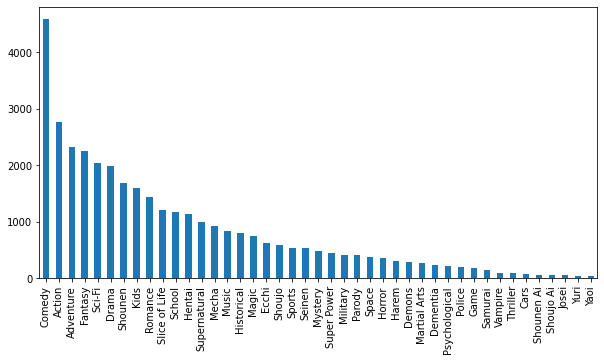

In [ ]:
dfx_genre.sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

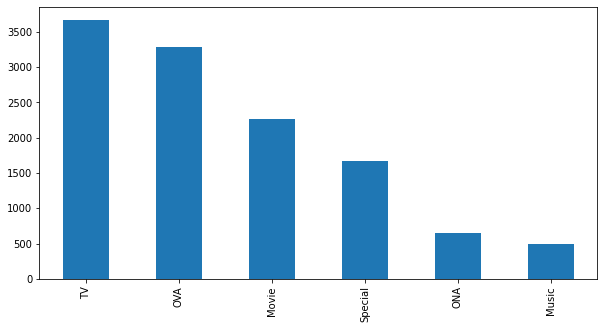

In [ ]:
dfx_type = pd.get_dummies(pd.DataFrame(anime_df['type'].tolist()).stack()).sum(level=0)
dfx_type.sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

**Picking top genre**

In [ ]:
drop_columns = dfx_genre.sum().sort_values(ascending=False)[13:].index.tolist()
anime_df.drop(columns=drop_columns,axis=1, inplace=True)
anime_df.head()

,anime_id,name,type,episodes,rating,members,Action,Adventure,Comedy,Drama,Fantasy,Hentai,Kids,Romance,School,Sci-Fi,Shounen,Slice of Life,Supernatural
0,32281,Kimi no Na wa.,Movie,1,9.37,200630,0,0,0,1,0,0,0,1,1,0,0,0,1
1,5114,Fullmetal Alchemist: Brotherhood,TV,64,9.26,793665,1,1,0,1,1,0,0,0,0,0,1,0,0
2,28977,Gintama°,TV,51,9.25,114262,1,0,1,0,0,0,0,0,0,1,1,0,0
3,9253,Steins;Gate,TV,24,9.17,673572,0,0,0,0,0,0,0,0,0,1,0,0,0
4,9969,Gintama&#039;,TV,51,9.16,151266,1,0,1,0,0,0,0,0,0,1,1,0,0


In [ ]:
# anime_df[['members', 'name']].plot(x='name', y='members', kind='bar', figsize=(10,3))

**Removing all characters except letters and numbers**

In [ ]:
import re
def transform(string):
    return re.sub(r"[^a-zA-Z0-9 ]","",string)


In [ ]:
anime_df_transformed = anime_df['name'].apply(transform)
anime_df_transformed

0                                            Kimi no Na wa
1                          Fullmetal Alchemist Brotherhood
2                                                  Gintama
3                                               SteinsGate
4                                               Gintama039
                               ...                        
12012           Toushindai My Lover Minami tai MechaMinami
12013                                          Under World
12014                       Violence Gekiga David no Hoshi
12015    Violence Gekiga Shin David no Hoshi Inma Densetsu
12016                        Yasuji no Pornorama Yacchimae
Name: name, Length: 12017, dtype: object

**Unsupervised learning of FastText to learn English and Japanese both names**

In [ ]:
dim_shape = 250 # reached by tuning over mae

In [ ]:
# pd.DataFrame(anime_df_transformed).to_csv('/content/anime_names.csv', index=False)
# fasttext_model=fasttext.train_unsupervised('/content/anime_names.csv', dim=dim_shape)
# fasttext_model.save_model('/content/drive/MyDrive/daraz/fasttext.bin')

In [ ]:
fasttext_model = fasttext.load_model('/content/daraz/fasttext.bin')

**Getting Embeddings for every word in anime name and then taking average embedding of each anime name word and then using those embeddings for whole name as features and concatinating features all together**

Idea was inspired by Deep Avergaing Network

ref: https://www.weak-learner.com/blog/2019/07/31/deep-averaging-networks/

In [ ]:
def name_emb(name):
    emb = [fasttext_model.get_word_vector(x) for x in name.split(' ')]
    return np.mean(emb, axis=0)

In [ ]:
anime_df_emb = anime_df['name'].apply(name_emb)
feat_data = pd.DataFrame(anime_df_emb.values.tolist(), columns=[f"feat_{i}" for i in range(dim_shape)])
anime_df = pd.concat([anime_df, feat_data], axis=1).drop(columns=['name'])
anime_df

,anime_id,type,episodes,rating,members,Action,Adventure,Comedy,Drama,Fantasy,Hentai,Kids,Romance,School,Sci-Fi,Shounen,Slice of Life,Supernatural,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,...,feat_210,feat_211,feat_212,feat_213,feat_214,feat_215,feat_216,feat_217,feat_218,feat_219,feat_220,feat_221,feat_222,feat_223,feat_224,feat_225,feat_226,feat_227,feat_228,feat_229,feat_230,feat_231,feat_232,feat_233,feat_234,feat_235,feat_236,feat_237,feat_238,feat_239,feat_240,feat_241,feat_242,feat_243,feat_244,feat_245,feat_246,feat_247,feat_248,feat_249
0,32281,Movie,1,9.37,200630,0,0,0,1,0,0,0,1,1,0,0,0,1,-0.214387,0.111015,-0.094270,-0.032956,0.022594,-0.039108,0.116235,0.047183,0.135931,0.135509,-0.003012,0.063235,0.125050,0.080858,-0.042632,0.032954,-0.022559,0.056038,-0.025435,-0.151745,-0.027663,0.139349,...,-0.169121,0.016775,-0.077749,-0.071051,-0.035220,0.108384,0.024388,0.048864,-0.048457,-0.006501,0.018452,-0.040852,-0.027150,0.072077,-0.005724,-0.121981,0.113725,-0.054598,-0.148346,0.026935,0.018263,0.134129,-0.029203,0.106309,-0.113242,-0.097135,-0.006942,0.191124,0.113578,0.111715,-0.113974,0.060310,0.114543,0.020924,0.043870,0.049057,0.137581,0.078716,0.019492,0.143723
1,5114,TV,64,9.26,793665,1,1,0,1,1,0,0,0,0,0,1,0,0,-0.151546,0.078806,-0.067846,-0.022826,0.016598,-0.028180,0.082083,0.034919,0.096509,0.095440,-0.002195,0.044228,0.088896,0.056955,-0.029783,0.023130,-0.014930,0.039281,-0.017698,-0.107635,-0.019527,0.098574,...,-0.119527,0.012069,-0.054762,-0.049897,-0.024957,0.075589,0.018037,0.035209,-0.033254,-0.004378,0.013683,-0.029367,-0.018211,0.050144,-0.003606,-0.086371,0.079721,-0.037493,-0.104228,0.018630,0.013338,0.094817,-0.021373,0.075803,-0.079497,-0.069908,-0.005532,0.134043,0.080819,0.079229,-0.082196,0.042344,0.080631,0.014351,0.030825,0.034245,0.096449,0.055265,0.013891,0.101504
2,28977,TV,51,9.25,114262,1,0,1,0,0,0,0,0,0,1,1,0,0,-0.158536,0.082122,-0.070940,-0.024135,0.017229,-0.029235,0.086263,0.036230,0.100626,0.099709,-0.002494,0.046112,0.093002,0.059530,-0.031865,0.024195,-0.015601,0.041482,-0.018435,-0.112214,-0.020591,0.102102,...,-0.125094,0.012446,-0.057071,-0.052195,-0.026334,0.079346,0.018482,0.036747,-0.035088,-0.004679,0.014153,-0.030624,-0.019169,0.052849,-0.003749,-0.089918,0.083548,-0.039191,-0.109242,0.019588,0.014103,0.099083,-0.021801,0.078865,-0.083533,-0.072518,-0.005558,0.140396,0.084582,0.082139,-0.085554,0.044312,0.084117,0.015060,0.032090,0.035796,0.100786,0.057955,0.014801,0.106171
3,9253,TV,24,9.17,673572,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.116347,0.060401,-0.052196,-0.017718,0.012822,-0.021801,0.063063,0.026677,0.074149,0.073013,-0.001649,0.033752,0.068333,0.043706,-0.023019,0.017781,-0.011462,0.030126,-0.013734,-0.082630,-0.015025,0.075739,...,-0.091615,0.009219,-0.041866,-0.038237,-0.019420,0.057895,0.013903,0.027321,-0.025770,-0.003173,0.010414,-0.022618,-0.013929,0.038484,-0.002777,-0.066312,0.061322,-0.028879,-0.079891,0.014278,0.010207,0.072682,-0.016364,0.058231,-0.061135,-0.053618,-0.004294,0.102644,0.061893,0.061011,-0.063224,0.032654,0.061755,0.010965,0.023442,0.026392,0.074139,0.042362,0.010460,0.077590
4,9969,TV,51,9.16,151266,1,0,1,0,0,0,0,0,0,1,1,0,0,-0.097960,0.050703,-0.043745,-0.014880,0.010799,-0.017899,0.053079,0.022488,0.062234,0.061685,-0.001701,0.028621,0.057557,0.036955,-0.019577,0.015246,-0.009634,0.025514,-0.011276,-0.069380,-0.012559,0.063361,...,-0.077084,0.007657,-0.035249,-0.032564,-0.016293,0.048959,0.011393,0.022494,-0.021658,-0.002825,0.008617,-0.018910,-0.011991,0.032500,-0.002302,-0.055667,0.051710,-0.024336,-0.067420,0.012041,0.008707,0.061232,-0.013553,0.048768,-0.051633,-0.044739,-0.003412,0.086714,0.052156,0.050821,-0.052795,0.027571,0.051842,0.009260,0.019666,0.022223,0.062254,0.035886,0.008963,0.065524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

**Doing normalization**

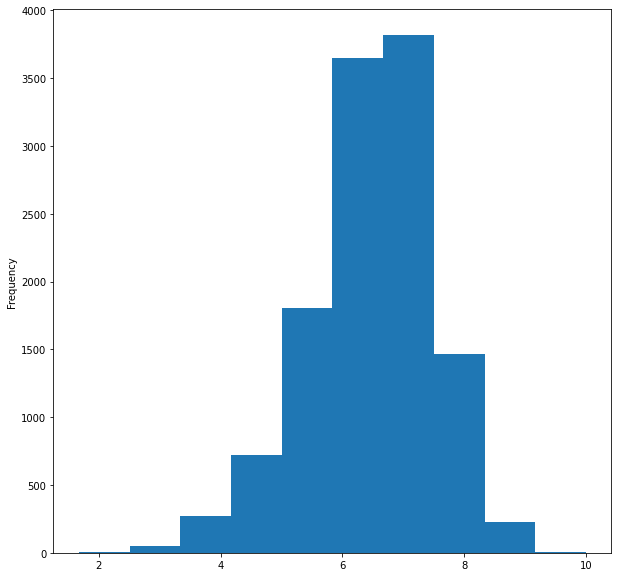

In [ ]:
anime_df['rating'].plot(kind='hist', figsize=(10,10))

In [ ]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
anime_df[['episodes', 'rating', 'members']] = scaler.fit_transform(anime_df[['episodes', 'rating', 'members']])
anime_df

,anime_id,type,episodes,rating,members,Action,Adventure,Comedy,Drama,Fantasy,Hentai,Kids,Romance,School,Sci-Fi,Shounen,Slice of Life,Supernatural,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,...,feat_210,feat_211,feat_212,feat_213,feat_214,feat_215,feat_216,feat_217,feat_218,feat_219,feat_220,feat_221,feat_222,feat_223,feat_224,feat_225,feat_226,feat_227,feat_228,feat_229,feat_230,feat_231,feat_232,feat_233,feat_234,feat_235,feat_236,feat_237,feat_238,feat_239,feat_240,feat_241,feat_242,feat_243,feat_244,feat_245,feat_246,feat_247,feat_248,feat_249
0,32281,Movie,-0.244919,2.824474,3.292044,0,0,0,1,0,0,0,1,1,0,0,0,1,-0.214387,0.111015,-0.094270,-0.032956,0.022594,-0.039108,0.116235,0.047183,0.135931,0.135509,-0.003012,0.063235,0.125050,0.080858,-0.042632,0.032954,-0.022559,0.056038,-0.025435,-0.151745,-0.027663,0.139349,...,-0.169121,0.016775,-0.077749,-0.071051,-0.035220,0.108384,0.024388,0.048864,-0.048457,-0.006501,0.018452,-0.040852,-0.027150,0.072077,-0.005724,-0.121981,0.113725,-0.054598,-0.148346,0.026935,0.018263,0.134129,-0.029203,0.106309,-0.113242,-0.097135,-0.006942,0.191124,0.113578,0.111715,-0.113974,0.060310,0.114543,0.020924,0.043870,0.049057,0.137581,0.078716,0.019492,0.143723
1,5114,TV,1.101630,2.717032,14.002410,1,1,0,1,1,0,0,0,0,0,1,0,0,-0.151546,0.078806,-0.067846,-0.022826,0.016598,-0.028180,0.082083,0.034919,0.096509,0.095440,-0.002195,0.044228,0.088896,0.056955,-0.029783,0.023130,-0.014930,0.039281,-0.017698,-0.107635,-0.019527,0.098574,...,-0.119527,0.012069,-0.054762,-0.049897,-0.024957,0.075589,0.018037,0.035209,-0.033254,-0.004378,0.013683,-0.029367,-0.018211,0.050144,-0.003606,-0.086371,0.079721,-0.037493,-0.104228,0.018630,0.013338,0.094817,-0.021373,0.075803,-0.079497,-0.069908,-0.005532,0.134043,0.080819,0.079229,-0.082196,0.042344,0.080631,0.014351,0.030825,0.034245,0.096449,0.055265,0.013891,0.101504
2,28977,TV,0.823771,2.707265,1.732216,1,0,1,0,0,0,0,0,0,1,1,0,0,-0.158536,0.082122,-0.070940,-0.024135,0.017229,-0.029235,0.086263,0.036230,0.100626,0.099709,-0.002494,0.046112,0.093002,0.059530,-0.031865,0.024195,-0.015601,0.041482,-0.018435,-0.112214,-0.020591,0.102102,...,-0.125094,0.012446,-0.057071,-0.052195,-0.026334,0.079346,0.018482,0.036747,-0.035088,-0.004679,0.014153,-0.030624,-0.019169,0.052849,-0.003749,-0.089918,0.083548,-0.039191,-0.109242,0.019588,0.014103,0.099083,-0.021801,0.078865,-0.083533,-0.072518,-0.005558,0.140396,0.084582,0.082139,-0.085554,0.044312,0.084117,0.015060,0.032090,0.035796,0.100786,0.057955,0.014801,0.106171
3,9253,TV,0.246678,2.629126,11.833499,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.116347,0.060401,-0.052196,-0.017718,0.012822,-0.021801,0.063063,0.026677,0.074149,0.073013,-0.001649,0.033752,0.068333,0.043706,-0.023019,0.017781,-0.011462,0.030126,-0.013734,-0.082630,-0.015025,0.075739,...,-0.091615,0.009219,-0.041866,-0.038237,-0.019420,0.057895,0.013903,0.027321,-0.025770,-0.003173,0.010414,-0.022618,-0.013929,0.038484,-0.002777,-0.066312,0.061322,-0.028879,-0.079891,0.014278,0.010207,0.072682,-0.016364,0.058231,-0.061135,-0.053618,-0.004294,0.102644,0.061893,0.061011,-0.063224,0.032654,0.061755,0.010965,0.023442,0.026392,0.074139,0.042362,0.010460,0.077590
4,9969,TV,0.823771,2.619358,2.400518,1,0,1,0,0,0,0,0,0,1,1,0,0,-0.097960,0.050703,-0.043745,-0.014880,0.010799,-0.017899,0.053079,0.022488,0.062234,0.061685,-0.001701,0.028621,0.057557,0.036955,-0.019577,0.015246,-0.009634,0.025514,-0.011276,-0.069380,-0.012559,0.063361,...,-0.077084,0.007657,-0.035249,-0.032564,-0.016293,0.048959,0.011393,0.022494,-0.021658,-0.002825,0.008617,-0.018910,-0.011991,0.032500,-0.002302,-0.055667,0.051710,-0.024336,-0.067420,0.012041,0.008707,0.061232,-0.013553,0.048768,-0.051633,-0.044739,-0.003412,0.086714,0.052156,0.050821,-0.052795,0.027571,0.051842,0.009260,0.019666,0.022223,0.062254,0.035886,0.008963,0.065524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,

**Creating new Feature by multiplying rating with members and dropping rating and members column because rating is directly proportional to number of people watching anime.**


In [ ]:
anime_df['rating*members'] = anime_df["rating"] * anime_df["members"]
anime_df = anime_df.drop(columns=['rating','members'])
anime_df

,anime_id,type,episodes,Action,Adventure,Comedy,Drama,Fantasy,Hentai,Kids,Romance,School,Sci-Fi,Shounen,Slice of Life,Supernatural,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,...,feat_211,feat_212,feat_213,feat_214,feat_215,feat_216,feat_217,feat_218,feat_219,feat_220,feat_221,feat_222,feat_223,feat_224,feat_225,feat_226,feat_227,feat_228,feat_229,feat_230,feat_231,feat_232,feat_233,feat_234,feat_235,feat_236,feat_237,feat_238,feat_239,feat_240,feat_241,feat_242,feat_243,feat_244,feat_245,feat_246,feat_247,feat_248,feat_249,rating*members
0,32281,Movie,-0.244919,0,0,0,1,0,0,0,1,1,0,0,0,1,-0.214387,0.111015,-0.094270,-0.032956,0.022594,-0.039108,0.116235,0.047183,0.135931,0.135509,-0.003012,0.063235,0.125050,0.080858,-0.042632,0.032954,-0.022559,0.056038,-0.025435,-0.151745,-0.027663,0.139349,0.108242,-0.094262,...,0.016775,-0.077749,-0.071051,-0.035220,0.108384,0.024388,0.048864,-0.048457,-0.006501,0.018452,-0.040852,-0.027150,0.072077,-0.005724,-0.121981,0.113725,-0.054598,-0.148346,0.026935,0.018263,0.134129,-0.029203,0.106309,-0.113242,-0.097135,-0.006942,0.191124,0.113578,0.111715,-0.113974,0.060310,0.114543,0.020924,0.043870,0.049057,0.137581,0.078716,0.019492,0.143723,9.298292
1,5114,TV,1.101630,1,1,0,1,1,0,0,0,0,0,1,0,0,-0.151546,0.078806,-0.067846,-0.022826,0.016598,-0.028180,0.082083,0.034919,0.096509,0.095440,-0.002195,0.044228,0.088896,0.056955,-0.029783,0.023130,-0.014930,0.039281,-0.017698,-0.107635,-0.019527,0.098574,0.076324,-0.065619,...,0.012069,-0.054762,-0.049897,-0.024957,0.075589,0.018037,0.035209,-0.033254,-0.004378,0.013683,-0.029367,-0.018211,0.050144,-0.003606,-0.086371,0.079721,-0.037493,-0.104228,0.018630,0.013338,0.094817,-0.021373,0.075803,-0.079497,-0.069908,-0.005532,0.134043,0.080819,0.079229,-0.082196,0.042344,0.080631,0.014351,0.030825,0.034245,0.096449,0.055265,0.013891,0.101504,38.044998
2,28977,TV,0.823771,1,0,1,0,0,0,0,0,0,1,1,0,0,-0.158536,0.082122,-0.070940,-0.024135,0.017229,-0.029235,0.086263,0.036230,0.100626,0.099709,-0.002494,0.046112,0.093002,0.059530,-0.031865,0.024195,-0.015601,0.041482,-0.018435,-0.112214,-0.020591,0.102102,0.079392,-0.069024,...,0.012446,-0.057071,-0.052195,-0.026334,0.079346,0.018482,0.036747,-0.035088,-0.004679,0.014153,-0.030624,-0.019169,0.052849,-0.003749,-0.089918,0.083548,-0.039191,-0.109242,0.019588,0.014103,0.099083,-0.021801,0.078865,-0.083533,-0.072518,-0.005558,0.140396,0.084582,0.082139,-0.085554,0.044312,0.084117,0.015060,0.032090,0.035796,0.100786,0.057955,0.014801,0.106171,4.689567
3,9253,TV,0.246678,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.116347,0.060401,-0.052196,-0.017718,0.012822,-0.021801,0.063063,0.026677,0.074149,0.073013,-0.001649,0.033752,0.068333,0.043706,-0.023019,0.017781,-0.011462,0.030126,-0.013734,-0.082630,-0.015025,0.075739,0.058479,-0.050302,...,0.009219,-0.041866,-0.038237,-0.019420,0.057895,0.013903,0.027321,-0.025770,-0.003173,0.010414,-0.022618,-0.013929,0.038484,-0.002777,-0.066312,0.061322,-0.028879,-0.079891,0.014278,0.010207,0.072682,-0.016364,0.058231,-0.061135,-0.053618,-0.004294,0.102644,0.061893,0.061011,-0.063224,0.032654,0.061755,0.010965,0.023442,0.026392,0.074139,0.042362,0.010460,0.077590,31.111756
4,9969,TV,0.823771,1,0,1,0,0,0,0,0,0,1,1,0,0,-0.097960,0.050703,-0.043745,-0.014880,0.010799,-0.017899,0.053079,0.022488,0.062234,0.061685,-0.001701,0.028621,0.057557,0.036955,-0.019577,0.015246,-0.009634,0.025514,-0.011276,-0.069380,-0.012559,0.063361,0.049175,-0.042473,...,0.007657,-0.035249,-0.032564,-0.016293,0.048959,0.011393,0.022494,-0.021658,-0.002825,0.008617,-0.018910,-0.011991,0.032500,-0.002302,-0.055667,0.051710,-0.024336,-0.067420,0.012041,0.008707,0.061232,-0.013553,0.048768,-0.051633,-0.044739,-0.003412,0.086714,0.052156,0.050821,-0.052795,0.027571,0.051842,0.009260,0.019666,0.022223,0.062254,0.035886,0.008963,0.065524,6.287815
...,...,...,...,...,...,...,...,...,...,...,...,.

**Dict to get weighted rating using anime id**

In [ ]:
animeid2weightedrating = dict(zip(anime_df['anime_id'], anime_df['rating*members']))

**Converting Type of the anime into multiple features(one hot Encode)**

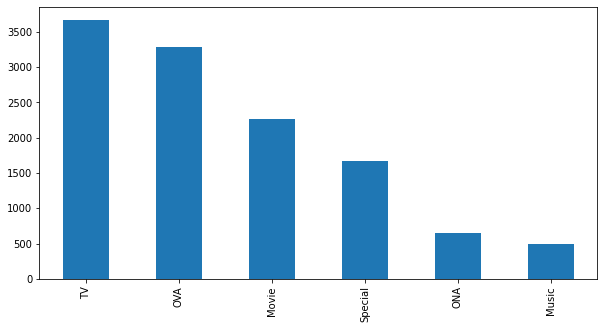

In [ ]:
dfx_type = pd.get_dummies(pd.DataFrame(anime_df['type'].tolist()).stack()).sum(level=0)
dfx_type.sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

In [ ]:
anime_df = pd.concat([anime_df, pd.get_dummies(anime_df['type'])], axis=1).drop(columns=['type'])
anime_df

,anime_id,episodes,Action,Adventure,Comedy,Drama,Fantasy,Hentai,Kids,Romance,School,Sci-Fi,Shounen,Slice of Life,Supernatural,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,...,feat_217,feat_218,feat_219,feat_220,feat_221,feat_222,feat_223,feat_224,feat_225,feat_226,feat_227,feat_228,feat_229,feat_230,feat_231,feat_232,feat_233,feat_234,feat_235,feat_236,feat_237,feat_238,feat_239,feat_240,feat_241,feat_242,feat_243,feat_244,feat_245,feat_246,feat_247,feat_248,feat_249,rating*members,Movie,Music,ONA,OVA,Special,TV
0,32281,-0.244919,0,0,0,1,0,0,0,1,1,0,0,0,1,-0.214387,0.111015,-0.094270,-0.032956,0.022594,-0.039108,0.116235,0.047183,0.135931,0.135509,-0.003012,0.063235,0.125050,0.080858,-0.042632,0.032954,-0.022559,0.056038,-0.025435,-0.151745,-0.027663,0.139349,0.108242,-0.094262,0.034045,...,0.048864,-0.048457,-0.006501,0.018452,-0.040852,-0.027150,0.072077,-0.005724,-0.121981,0.113725,-0.054598,-0.148346,0.026935,0.018263,0.134129,-0.029203,0.106309,-0.113242,-0.097135,-0.006942,0.191124,0.113578,0.111715,-0.113974,0.060310,0.114543,0.020924,0.043870,0.049057,0.137581,0.078716,0.019492,0.143723,9.298292,1,0,0,0,0,0
1,5114,1.101630,1,1,0,1,1,0,0,0,0,0,1,0,0,-0.151546,0.078806,-0.067846,-0.022826,0.016598,-0.028180,0.082083,0.034919,0.096509,0.095440,-0.002195,0.044228,0.088896,0.056955,-0.029783,0.023130,-0.014930,0.039281,-0.017698,-0.107635,-0.019527,0.098574,0.076324,-0.065619,0.024160,...,0.035209,-0.033254,-0.004378,0.013683,-0.029367,-0.018211,0.050144,-0.003606,-0.086371,0.079721,-0.037493,-0.104228,0.018630,0.013338,0.094817,-0.021373,0.075803,-0.079497,-0.069908,-0.005532,0.134043,0.080819,0.079229,-0.082196,0.042344,0.080631,0.014351,0.030825,0.034245,0.096449,0.055265,0.013891,0.101504,38.044998,0,0,0,0,0,1
2,28977,0.823771,1,0,1,0,0,0,0,0,0,1,1,0,0,-0.158536,0.082122,-0.070940,-0.024135,0.017229,-0.029235,0.086263,0.036230,0.100626,0.099709,-0.002494,0.046112,0.093002,0.059530,-0.031865,0.024195,-0.015601,0.041482,-0.018435,-0.112214,-0.020591,0.102102,0.079392,-0.069024,0.025401,...,0.036747,-0.035088,-0.004679,0.014153,-0.030624,-0.019169,0.052849,-0.003749,-0.089918,0.083548,-0.039191,-0.109242,0.019588,0.014103,0.099083,-0.021801,0.078865,-0.083533,-0.072518,-0.005558,0.140396,0.084582,0.082139,-0.085554,0.044312,0.084117,0.015060,0.032090,0.035796,0.100786,0.057955,0.014801,0.106171,4.689567,0,0,0,0,0,1
3,9253,0.246678,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.116347,0.060401,-0.052196,-0.017718,0.012822,-0.021801,0.063063,0.026677,0.074149,0.073013,-0.001649,0.033752,0.068333,0.043706,-0.023019,0.017781,-0.011462,0.030126,-0.013734,-0.082630,-0.015025,0.075739,0.058479,-0.050302,0.018721,...,0.027321,-0.025770,-0.003173,0.010414,-0.022618,-0.013929,0.038484,-0.002777,-0.066312,0.061322,-0.028879,-0.079891,0.014278,0.010207,0.072682,-0.016364,0.058231,-0.061135,-0.053618,-0.004294,0.102644,0.061893,0.061011,-0.063224,0.032654,0.061755,0.010965,0.023442,0.026392,0.074139,0.042362,0.010460,0.077590,31.111756,0,0,0,0,0,1
4,9969,0.823771,1,0,1,0,0,0,0,0,0,1,1,0,0,-0.097960,0.050703,-0.043745,-0.014880,0.010799,-0.017899,0.053079,0.022488,0.062234,0.061685,-0.001701,0.028621,0.057557,0.036955,-0.019577,0.015246,-0.009634,0.025514,-0.011276,-0.069380,-0.012559,0.063361,0.049175,-0.042473,0.015577,...,0.022494,-0.021658,-0.002825,0.008617,-0.018910,-0.011991,0.032500,-0.002302,-0.055667,0.051710,-0.024336,-0.067420,0.012041,0.008707,0.061232,-0.013553,0.048768,-0.051633,-0.044739,-0.003412,0.086714,0.052156,0.050821,-0.052795,0.027571,0.051842,0.009260,0.019666,0.022223,0.062254,0.035886,0.008963,0.065524,6.287815,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# Content Based Filtering

**Finding Cosine Similarity of the shows and dropping Anime_id due to unique representation of it**

In [ ]:
cos_sin = cosine_similarity(anime_df.drop(columns=['anime_id']))

**Sort Cosine Similarities of given anime index**

In [ ]:
def get_argsort(index):
    return np.argsort(cos_sin[index])[::-1][:len(cos_sin[index])]
    # return np.argsort(cos_sin[index])

**Getting Anime_id and Anime_name using Anime_row_index**

In [ ]:
def get_id_name_cold_start(index):
    anime_id = index2animeid[index]
    anime_name = animeid2name[anime_id]
    weighted_rating = animeid2weightedrating[anime_id]
    return anime_id, anime_name, weighted_rating

def get_id_name(index):
    anime_id = index2animeid[index]
    anime_name = animeid2name[anime_id]
    return anime_id, anime_name

**Getting top 10 similar animes from given anime_id**

In [ ]:
def get_similar_animes(my_anime_id):
    animes = []
    sorted_index = get_argsort(animeid2index[my_anime_id])
    for i in range(1, 11):
        animes.append(get_id_name(sorted_index[i]))
    return animes

def get_similar_animes_cold_start(my_anime_id):
    animes = []
    sorted_index = get_argsort(animeid2index[my_anime_id])
    for i in range(1, 11):
        animes.append(get_id_name_cold_start(sorted_index[i]))
    return animes

**Get Similar Animes using anime_id**

In [ ]:
my_anime_id = 813
print("Movie  : ",  animeid2name[my_anime_id])
print("Movie index   : ",  animeid2index[my_anime_id])
top_10_animes = get_similar_animes(my_anime_id)

print(f'\n\nTop 10 similar Animes:')
for anime in top_10_animes:
    print(anime)

Movie  :  Dragon Ball Z
Movie index   :  206


Top 10 similar Animes:
(1604, 'Katekyo Hitman Reborn!')
(269, 'Bleach')
(223, 'Dragon Ball')
(20, 'Naruto')
(249, 'InuYasha')
(918, 'Gintama')
(22043, 'Fairy Tail (2014)')
(392, 'Yuu☆Yuu☆Hakusho')
(6702, 'Fairy Tail')
(1482, 'D.Gray-man')


# Collaborative Filtering

**Separating Rows which has no rating by User**

In [ ]:
rating_df_truncated = rating_df[rating_df.rating != -1]
rating_df_truncated.reset_index(inplace=True, drop=True)
rating_df_truncated

,user_id,anime_id,rating
0,1.000000e+00,8074,10.0
1,1.000000e+00,11617,10.0
2,1.000000e+00,11757,10.0
3,1.000000e+00,15451,10.0
4,2.000000e+00,11771,10.0
...,...,...,...
6337246,6.000000e+12,9253,10.0
6337247,6.000000e+12,19,8.0
6337248,6.000000e+12,33,9.0
6337249,6.000000e+12,1889,7.0


In [ ]:
rating_df_truncated_no_rating = rating_df[rating_df.rating == -1]
rating_df_truncated_no_rating.reset_index(inplace=True, drop=True)
rating_df_truncated_no_rating

,user_id,anime_id,rating
0,1.0,20,-1.0
1,1.0,24,-1.0
2,1.0,79,-1.0
3,1.0,226,-1.0
4,1.0,241,-1.0
...,...,...,...
1476491,73515.0,2385,-1.0
1476492,73515.0,2386,-1.0
1476493,73515.0,2490,-1.0
1476494,73515.0,2680,-1.0


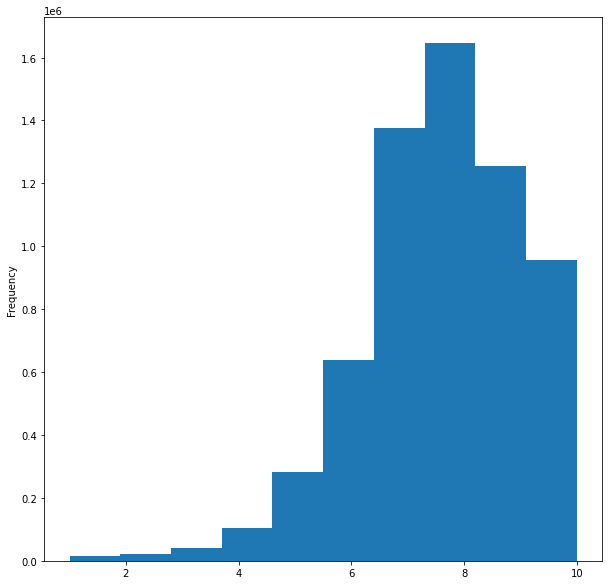

In [ ]:
rating_df_truncated['rating'].plot(kind='hist', figsize=(10,10))

**Splitting Data into Train and Test Splits**

In [ ]:
X = rating_df_truncated[['user_id', 'anime_id']]
y = rating_df_truncated[['rating']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

**DownSampling of Data**

In [ ]:
# truncated_train = pd.concat([X_train, y_train], axis=1)
# truncated_train
# truncated_train_new = truncated_train.sample(frac =.5)
# truncated_train_new

**Training RandomForestRegressor**

In [ ]:
# RFReg = RandomForestRegressor(n_estimators=100, max_depth=10)
# RFReg.fit(X_train, y_train)


In [ ]:
# joblib.dump(RFReg, '/content/drive/MyDrive/daraz/RFReg.model')
RFReg = joblib.load('/content/daraz/RFReg.model')

In [ ]:
y_pred = RFReg.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

1.200852620843829
2.3656929276309597


**Training GradientBoostingRegressor**

In [ ]:
# GBReg = GradientBoostingRegressor()
# GBReg.fit(X_train, y_train)

In [ ]:
# joblib.dump(GBReg, '/content/GBReg.model')
# joblib.dump(GBReg, '/content/drive/MyDrive/daraz/GBReg.model')
GBReg = joblib.load('/content/daraz/GBReg.model')


**Evaluating Metrics**

In [ ]:
y_pred = GBReg.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

1.2108169671768734
2.3954841792892383


In [ ]:
# reg.predict(X_test[1:2])
# reg.score(X_test, y_test)

**Training LinearRegression**

In [ ]:
# LReg = LinearRegression().fit(X_train, y_train)
# LReg.score(X, y)
# LReg.coef_
# LReg.intercept_
# joblib.dump(LReg, '/content/drive/MyDrive/daraz/Linear_Regression.sav')


In [ ]:
LReg = joblib.load('/content/daraz/Linear_Regression.sav')

**Evaluating Metrics**

In [ ]:
y_pred = LReg.predict(X_test)
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

2.008946006089514
531553.1881055671


**Ensembling**

In [ ]:
y_pred_RFReg = RFReg.predict(X_test)
y_pred_GBReg = GBReg.predict(X_test)
y_pred_LRreg = LReg.predict(X_test)
y_pred_LRreg = y_pred_LRreg.reshape((X_test.shape[0],))

y_pred = np.mean([y_pred_RFReg, y_pred_GBReg], axis=0)

print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

1.202565110119168
2.3635202015184227


In [ ]:
# print(mean_absolute_error(y_test, y_pred))
# print(mean_squared_error(y_test, y_pred))

In [ ]:
rating_df_truncated_no_rating

,user_id,anime_id,rating
0,1.0,20,-1.0
1,1.0,24,-1.0
2,1.0,79,-1.0
3,1.0,226,-1.0
4,1.0,241,-1.0
...,...,...,...
1476491,73515.0,2385,-1.0
1476492,73515.0,2386,-1.0
1476493,73515.0,2490,-1.0
1476494,73515.0,2680,-1.0


**Predicting Ratings on non Rated Animes by User**

In [ ]:
X_test_no_rating = rating_df_truncated_no_rating[['user_id', 'anime_id']]
RFReg.predict(X_test_no_rating)

array([7.98009559, 3.71674258, 7.88550024, ..., 7.07155391, 7.77021712,
       7.81421228])

# Content + Collaborative Based Filtering

**Getting Top 10 animes of user and Recommending 10 animes on each then returning animes upto 100, after removing already watched and duplicates**

In [ ]:
def cold_start_solution(user_id):
    animes = []

    # getting animes_ids of animes user have watched in descending order with respect to rating given by user
    anime_ids =rating_df.sort_values('rating', ascending=False)['anime_id'].values

    # Keeping only top 10 rated animes
    if len(anime_ids) > 10:
        anime_ids = anime_ids[:10]

    # Getting Top 10 similar animes on each anime watched by user
    for my_anime_id in anime_ids:
        animes = animes + get_similar_animes_cold_start(my_anime_id)
    animes_df = pd.DataFrame(animes, columns=['anime_id', 'anime_name', 'weighted_rating'])
    animes_df['user_id'] = user_id

    # Ranking top animes based on weighted ratings
    animes_df = animes_df.sort_values('weighted_rating', ascending=False)

    #Removing Duplicates
    animes_df = animes_df.drop_duplicates()

    # Returning 
    return animes_df[['anime_id', 'anime_name', 'weighted_rating']]

In [ ]:
def get_top_animes_for_user(user_id):
    animes = []

    # getting animes_ids of animes user have watched in descending order with respect to rating given by user
    anime_ids = rating_df.loc[rating_df['user_id'] == user_id].sort_values('rating', ascending=False)['anime_id'].values

    # Cold stary condition
    # is_cold_start = False
    if len(anime_ids) < 1:
        return cold_start_solution(user_id)
        # return animes_df[['anime_id', 'anime_name', 'rating*members']]
        
    # making copy of anime_ids so that it can be use to remove already watched animes
    watched_animes = anime_ids.copy()

    # Keeping only top 10 rated animes by user
    if len(anime_ids) > 10:
        anime_ids = anime_ids[:10]

    # Getting Top 10 similar animes on each anime watched by user
    for my_anime_id in anime_ids:
        animes = animes + get_similar_animes(my_anime_id)
    animes_df = pd.DataFrame(animes, columns=['anime_id', 'anime_name'])
    animes_df['user_id'] = user_id

    # Predicting Ratingg on Fetched Similar Animes
    X = animes_df[['user_id', 'anime_id']]

    y_pred_RFReg = RFReg.predict(X)
    y_pred_GBReg = GBReg.predict(X)
    y_pred = np.mean([y_pred_RFReg, y_pred_GBReg], axis=0)

    animes_df['predicted_rating'] = y_pred

    # Removing Already Watched Animes if any
    animes_df = animes_df[~animes_df['anime_id'].isin(watched_animes)]

    # Sorting Animes in Descending order with respect to rating
    animes_df = animes_df.sort_values('predicted_rating', ascending=False)

    #Removing Duplicates
    animes_df = animes_df.drop_duplicates()

    # Returning
    return animes_df[['anime_id', 'anime_name', 'predicted_rating']]

In [ ]:
# user_id = 3000000000000
user_id = 6000000000000
# user_id = 3
result = get_top_animes_for_user(user_id)
result[:10]

NameError: ignored

# API

In [ ]:
app = Flask(__name__)
run_with_ngrok(app)   
  
@app.route('/recommendation', methods=['GET', 'POST'])
def main():
    user_id = int(request.args.get('user_id'))
    # http://127.0.0.1:5000/recommendation?user_id=Python
    result = get_top_animes_for_user(user_id)
    return result.to_json(orient="values")
    
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c5e5-35-197-91-66.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [29/Sep/2021 11:49:59] "GET /recommendation?user_id=3 HTTP/1.1" 200 -
127.0.0.1 - - [29/Sep/2021 11:50:12] "GET /recommendation?user_id=5467 HTTP/1.1" 200 -
[2021-09-29 11:50:27,235] ERROR in app: Exception on /recommendation [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1936, in dispatch_